# Reading and visualising data

In [1]:
import numpy as np
import tools21cm as t2c

Different simulations codes write their output in different formats. It is same for observations, which will differ based of the observation facility and research group. One has to define a function that is specific to that case.

In order to manipulate and analyse data with tools21cm, we want the data to be read in as numpy array. 

### Reading data
Here we read the ionisation fraction data cube produced with the [C2Ray](https://github.com/garrelt/C2-Ray3Dm) code. For the density field, we will consider the gridded density field created by an N-body, [CubeP3M](https://github.com/jharno/cubep3m), which were used by [C2Ray](https://github.com/garrelt/C2-Ray3Dm) code as input.

We provide few simulation outputs for test: https://doi.org/10.5281/zenodo.3953639

In [2]:
path_to_datafiles = './data/'
z = 7.059

In [3]:
t2c.set_sim_constants(244) # This line is only useful while working with C2Ray simulations.

x_file = t2c.XfracFile(path_to_datafiles+'xfrac3d_7.059.bin')
d_file = t2c.DensityFile(path_to_datafiles+'7.059n_all.dat')

xfrac = x_file.xi
dens  = d_file.cgs_density

The above function `set_sim_constants` is useful only for `C2Ray` simulation outputs. This function takes as its only parameter the box side in cMpc/h and sets simulations constants.

See [here](https://tools21cm.readthedocs.io/contents.html#module-t2c.read_files) for more data reading functions.

### Visualising the data

You can of course plot the data you read using your favorite plotting software. For example, if you have `matplotlib` installed.

In [4]:
import matplotlib.pyplot as plt

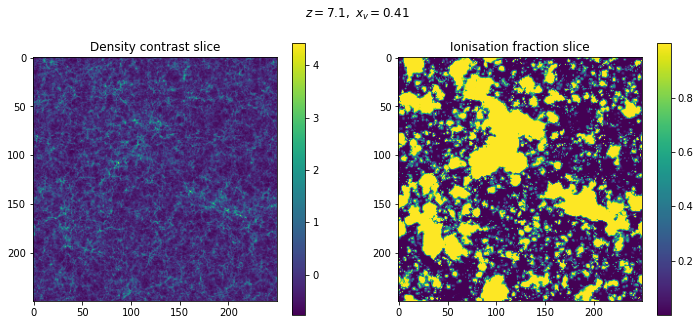

In [5]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.suptitle('$z={0:.1f},~x_v=${1:.2f}'.format(z,xfrac.mean()))

plt.subplot(121)
plt.title('Density contrast slice')
plt.imshow(dens[0,:,:]/dens.mean()-1)
plt.colorbar()

plt.subplot(122)
plt.title('Ionisation fraction slice')
plt.imshow(xfrac[0,:,:])
plt.colorbar()

plt.show()

# 21 cm brightness temperature

We can construct the 21 cm brightness temperature from the density field and ionisation fraction field using `calc_dt`. Due to the absence of zero baseline, the mean signal will be subtracted from each frequency channel. One can use `subtract_mean_channelwise` to add this effect.

In [6]:
dT = t2c.calc_dt(xfrac, dens, z)
dT_subtracted = t2c.subtract_mean_channelwise(dT, axis=2)

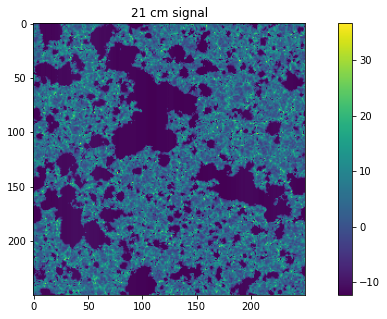

In [7]:
plt.rcParams['figure.figsize'] = [12, 5]

plt.title('21 cm signal')
plt.imshow(dT_subtracted[0,:,:])
plt.colorbar()

plt.show()

### 21 cm power spectrum

One of the most interesting metric to analyse this field is the power spectrum. Below we estimate the spherically average power spectrum.

In [8]:
box_dims = 244/0.7 # in Mpc

In [9]:
ps, ks = t2c.power_spectrum_1d(dT_subtracted, kbins=15, box_dims=box_dims)

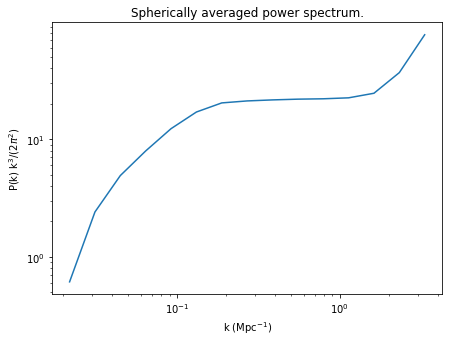

In [10]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.title('Spherically averaged power spectrum.')
plt.loglog(ks, ps*ks**3/2/np.pi**2)
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel('P(k) k$^{3}$/$(2\pi^2)$')

plt.show()

# Redshift-space distortions

The 21 cm signal will be modified while mapping from real space to redshift space due to peculiar velocities ([Mao et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.422..926M/abstract)).

The `VelocityFile` function is used to read the velocity files produced by `CubeP3M`. We need the velocities in km/s as a numpy array of shape `(3,nGridx,nGridy,nGridyz)`, where the first axis represent the velocity component along x, y and z spatial direction. The `get_kms_from_density` attribute gives such a numpy array.

In [11]:
v_file = t2c.VelocityFile(path_to_datafiles+'7.059v_all.dat')

In [12]:
kms = v_file.get_kms_from_density(d_file)

The `get_distorted_dt` function will distort the signal.

In [13]:
dT_rsd = t2c.get_distorted_dt(dT, kms, z, 
                              los_axis=2, 
                              velocity_axis=2, 
                              num_particles=50)

Spherically averaged power spectrum of the 21 cm signal with RSD.

In [14]:
ps_rsd, ks_rsd = t2c.power_spectrum_1d(dT_rsd, kbins=15, box_dims=box_dims)

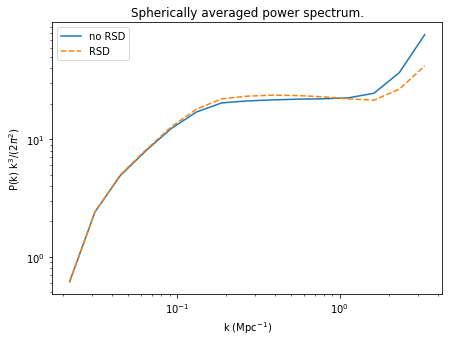

In [15]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.title('Spherically averaged power spectrum.')
plt.loglog(ks, ps*ks**3/2/np.pi**2, label='no RSD')
plt.loglog(ks_rsd, ps_rsd*ks_rsd**3/2/np.pi**2, linestyle='--', label='RSD')

plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel('P(k) k$^{3}$/$(2\pi^2)$')
plt.legend()

plt.show()

We see in the above figure that the spherically averaged power spectrum has changed after RSD is implemented.

However, a better marker of RSD in 21 cm signal is the power spectrum's $\mu (\equiv k_\parallel/k)$ dependence ([Jensen et al. 2013](https://academic.oup.com/mnras/article/435/1/460/1123792)). The power spectrum of 21 cm signal with RSD will have the following dependence ([Barkana & Loeb 2005](https://iopscience.iop.org/article/10.1086/430599)),

$P(k,\mu) = P_0 + \mu^2P_2 +\mu^4P_4$.

We can calculate $P(k,\mu)$ using `power_spectrum_mu` function.

In [16]:
Pk, mubins, kbins, nmode = t2c.power_spectrum_mu(
    dT,
    los_axis=2,
    mubins=10,
    kbins=14,
    box_dims=box_dims,
    exclude_zero_modes=True,
    return_n_modes=True,
    absolute_mus=False,
)

/Users/sambitgiri/opt/anaconda3/envs/py3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [17]:
Pk_rsd, mubins_rsd, kbins_rsd, nmode_rsd = t2c.power_spectrum_mu(
    dT_rsd,
    los_axis=2,
    mubins=10,
    kbins=14,
    box_dims=box_dims,
    exclude_zero_modes=True,
    return_n_modes=True,
    absolute_mus=False,
)

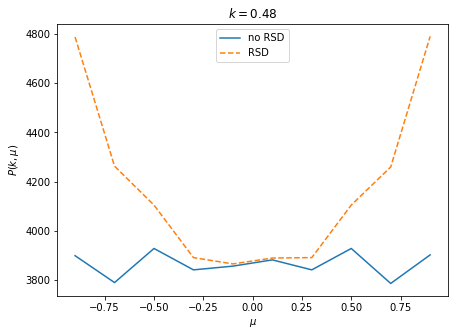

In [18]:
plt.rcParams['figure.figsize'] = [7, 5]
ii = 8

plt.title('$k={0:.2f}$'.format(kbins[ii]))
plt.plot(mubins, Pk[:,ii], label='no RSD')
plt.plot(mubins_rsd, Pk_rsd[:,ii], linestyle='--', label='RSD')

plt.xlabel('$\mu$')
plt.ylabel('$P(k,\mu)$')
plt.legend()

plt.show()

# Bubble size distribution

The bubble (HII regions) size distribution is an intersting probe of the reionization process ([Giri et al. 2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.473.2949G/abstract)).

`Tools21cm` contains three methods to determine the size distributions, which are Friends-of-friends, Spherical average and mean free path approach.

In this tutorial, we will take the ionisation fraction field and assume all the pixels with value $>0.5$ as ionised.

In [19]:
xHII = xfrac>0.5

boxsize = 244/0.7 # in Mpc

Mean free path (e.g. [Mesinger & Furlanetto 2007](https://iopscience.iop.org/article/10.1086/521806/meta))

In [20]:
r_mfp, dn_mfp = t2c.mfp(xHII, boxsize=boxsize, iterations=1000000)

MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 0.083736 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.


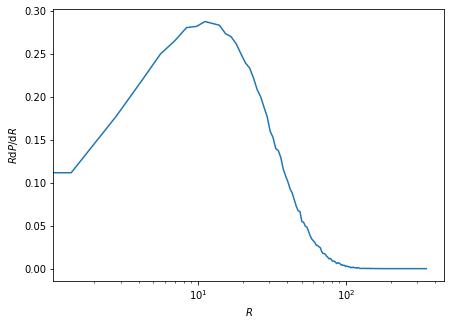

In [21]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.semilogx(r_mfp, dn_mfp)

plt.xlabel('$R$')
plt.ylabel('$R\mathrm{d}P/\mathrm{d}R$')

plt.show()

Spherical average (e.g. [Zahn et al. 2007](https://ui.adsabs.harvard.edu/abs/2007ApJ...654...12Z/abstract))

In [22]:
r_spa, dn_spa = t2c.spa(xHII, boxsize=boxsize, nscales=20)

Comepleted 5.0 %
Comepleted 10.0 %
Comepleted 15.0 %
Comepleted 20.0 %
Comepleted 25.0 %
Comepleted 30.0 %
Comepleted 35.0 %
Comepleted 40.0 %
Comepleted 45.0 %
Comepleted 50.0 %
Comepleted 55.0 %
Comepleted 60.0 %
Comepleted 65.0 %
Comepleted 70.0 %
Comepleted 75.0 %
Comepleted 80.0 %
Comepleted 85.0 %
Comepleted 90.0 %
Comepleted 95.0 %
Comepleted 100.0 %


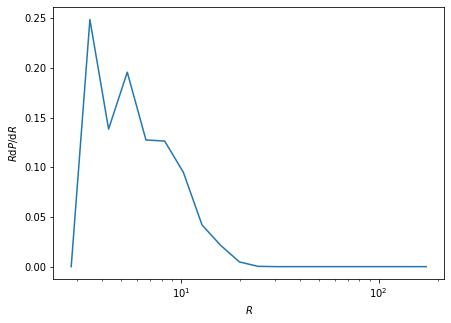

In [23]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.semilogx(r_spa, dn_spa)

plt.xlabel('$R$')
plt.ylabel('$R\mathrm{d}P/\mathrm{d}R$')

plt.show()

Friends of friends (e.g. [Iliev et al. 2006](https://ui.adsabs.harvard.edu/abs/2006MNRAS.369.1625I/abstract))

In [24]:
labelled_map, volumes = t2c.fof(xHII, use_skimage=True)
fof_dist = t2c.plot_fof_sizes(volumes, bins=30, boxsize=boxsize)

Program runtime: 0.008363 minutes.
The output is a tuple containing output-map and volume-list array respectively.
The output is Size, Size**2 dP/d(Size), lowest value


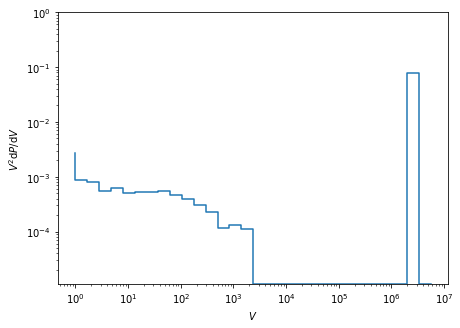

In [25]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.step(fof_dist[0], fof_dist[1])
plt.xscale('log')
plt.yscale('log')
plt.ylim(fof_dist[2],1)

plt.xlabel('$V$')
plt.ylabel('$V^2\mathrm{d}P/\mathrm{d}V$')

plt.show()